# Censusdis Data Download

Using censusdis to download population and income data for Contra Costa County 

## Imports and configuration

In [27]:
%pip install censusdis

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt

from typing import Optional

import censusdis.data as ced
import censusdis.maps as cem
import censusdis.values as cev
from censusdis import states

## Identify dataset and variables

In [2]:
# American Community Survey 5-Year Data
# https://www.census.gov/data/developers/data-sets/acs-5year.html
DATASET = "acs/acs5"

# The year we want data for.
YEAR = 2020

# This are the census variables for total population and median household income.
# For more details, see
#
#     https://api.census.gov/data/2020/acs/acs5/variables.html,
#     https://api.census.gov/data/2020/acs/acs5/variables/B01003_001E.html, and
#     https://api.census.gov/data/2020/acs/acs5/variables/B19013_001E.html.
#
TOTAL_POPULATION_VARIABLE = "B01003_001E"
MEDIAN_HOUSEHOLD_INCOME_VARIABLE = "B19013_001E"
AVERAGE_HOUSEHOLD_SIZE = "B25010_001E"

# The variables we are going to query.
VARIABLES = ["NAME", TOTAL_POPULATION_VARIABLE, MEDIAN_HOUSEHOLD_INCOME_VARIABLE, AVERAGE_HOUSEHOLD_SIZE]

## State level

In [3]:
# Get the value of our variables for every state in the
# year we have chosen.
df_states = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state="*",
)

In [4]:
print(df_states)

   STATE                  NAME  B01003_001E  B19013_001E  B25010_001E
0     42          Pennsylvania     12794885        63627         2.42
1     06            California     39346023        78672         2.94
2     54         West Virginia      1807426        48037         2.40
3     49                  Utah      3151239        74197         3.09
4     36              New York     19514849        71117         2.55
5     11  District of Columbia       701974        90842         2.30
6     02                Alaska       736990        77790         2.78
7     12               Florida     21216924        57703         2.62
8     45        South Carolina      5091517        54864         2.53
9     38          North Dakota       760394        65315         2.29
10    23                 Maine      1340825        59489         2.29
11    13               Georgia     10516579        61224         2.68
12    01               Alabama      4893186        52035         2.53
13    33         New

## Counties

In [5]:
from censusdis.states import STATE_CA

df_counties = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE_CA,
    county="*",
)

In [6]:
print(df_counties)

   STATE COUNTY                                NAME  B01003_001E  B19013_001E  \
0     06    001          Alameda County, California      1661584       104888   
1     06    003           Alpine County, California         1159        85750   
2     06    007            Butte County, California       223344        54972   
3     06    011           Colusa County, California        21491        59427   
4     06    013     Contra Costa County, California      1147788       103997   
5     06    017        El Dorado County, California       190345        83710   
6     06    019           Fresno County, California       990204        57109   
7     06    023         Humboldt County, California       136101        49235   
8     06    025         Imperial County, California       180580        46222   
9     06    029             Kern County, California       892458        54851   
10    06    031            Kings County, California       151090        61556   
11    06    035           La

## Block Groups

In [7]:
COUNTY_ContraCosta_CA = "013"  # See county query above.

df_bg = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE_CA,
    county=COUNTY_ContraCosta_CA,
    block_group="*",
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

In [8]:
print(df_bg[:10].to_string(line_width=200))
print()
print("...")
print()
print(df_bg[-10:].to_string(line_width=200))

  STATE COUNTY   TRACT BLOCK_GROUP                                                                  NAME  B01003_001E  B19013_001E  B25010_001E
0    06    013  340003           2  Block Group 2, Census Tract 3400.03, Contra Costa County, California          638          NaN         2.39
1    06    013  340004           2  Block Group 2, Census Tract 3400.04, Contra Costa County, California         1349     189479.0         2.88
2    06    013  341000           2     Block Group 2, Census Tract 3410, Contra Costa County, California         1731     210679.0         2.89
3    06    013  343001           2  Block Group 2, Census Tract 3430.01, Contra Costa County, California          836     111983.0         2.33
4    06    013  343002           1  Block Group 1, Census Tract 3430.02, Contra Costa County, California         1953     103173.0         2.56
5    06    013  343003           2  Block Group 2, Census Tract 3430.03, Contra Costa County, California         1568     141250.0      

## Query Geographies

In [9]:
import censusdis.geography as cgeo

specs = cgeo.geo_path_snake_specs(DATASET, YEAR)

In [10]:
import pprint

pprint.pprint(specs)

{'010': ['us'],
 '020': ['region'],
 '030': ['division'],
 '040': ['state'],
 '050': ['state', 'county'],
 '060': ['state', 'county', 'county_subdivision'],
 '067': ['state', 'county', 'county_subdivision', 'subminor_civil_division'],
 '070': ['state', 'county', 'county_subdivision', 'place_remainder_or_part'],
 '140': ['state', 'county', 'tract'],
 '150': ['state', 'county', 'tract', 'block_group'],
 '155': ['state', 'place', 'county_or_part'],
 '160': ['state', 'place'],
 '170': ['state', 'consolidated_city'],
 '172': ['state', 'consolidated_city', 'place_or_part'],
 '230': ['state', 'alaska_native_regional_corporation'],
 '250': ['american_indian_area_alaska_native_area_hawaiian_home_land'],
 '251': ['american_indian_area_alaska_native_area_hawaiian_home_land',
         'tribal_subdivision_remainder'],
 '252': ['american_indian_area_alaska_native_area_reservation_or_statistical_entity_only'],
 '254': ['american_indian_area_off_reservation_trust_land_only_hawaiian_home_land'],
 '256'

# Data With Geometry

We can load the geometry of geographical locations when we load the data associated with
them just by adding the `with_geoemetry=True` flag to a call
to `censusdis.data.download`.

This is a nice powerful feature because it saves us the time
of loading data and maps separately and dealing with the 
not-quite-matching column names we have to join them on. 
Setting this one flag saves us all that effort.

## Shapefile reader

In [11]:
reader = cem.ShapeReader(year=YEAR)

In [12]:
gdf_state_bounds = reader.read_cb_shapefile("us", "state")
gdf_state_bounds = gdf_state_bounds[
    gdf_state_bounds["STATEFP"].isin(states.ALL_STATES_AND_DC)
]

## Plot function

In [13]:
plt.rcParams["figure.figsize"] = (18, 8)


def plot_map(
    gdf: gpd.GeoDataFrame,
    geo: str,
    *,
    gdf_bounds: Optional[gpd.GeoDataFrame] = None,
    bounds_color: str = "white",
    max_income: float = 200_000.0,
    **kwargs,
):
    """Plot a map."""
    if gdf_bounds is None:
        gdf_bounds = gdf

    ax = cem.plot_us(gdf_bounds, color="lightgray")

    ax = cem.plot_us(
        gdf,
        MEDIAN_HOUSEHOLD_INCOME_VARIABLE,
        cmap="autumn",
        edgecolor="darkgray",
        legend=True,
        vmin=0.0,
        vmax=max_income,
        ax=ax,
        **kwargs,
    )

    ax = cem.plot_us_boundary(gdf_bounds, edgecolor=bounds_color, linewidth=0.5, ax=ax)

    ax.set_title(f"{YEAR} Median Household Income by {geo.title()}")

    ax.axis("off")

### Census Tract

In [14]:
STATE = states.CA

In [15]:
gdf_tract = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    tract="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

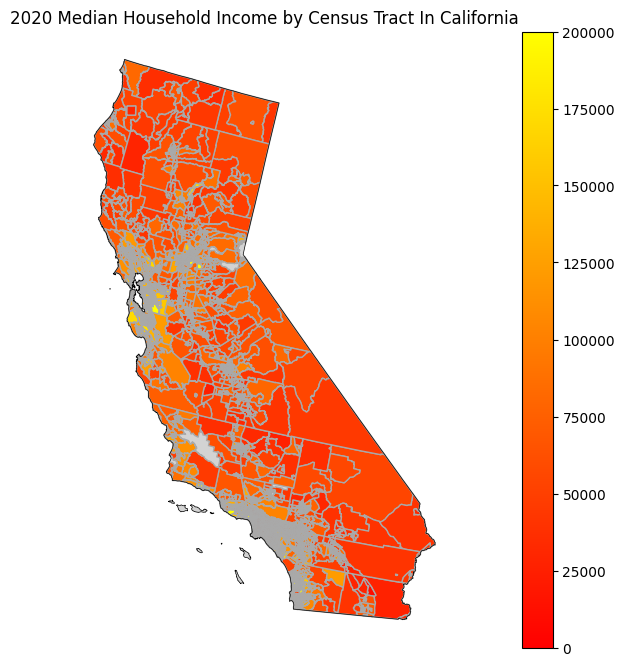

In [16]:
plot_map(
    gdf_tract,
    f"census tract in {states.NAMES_FROM_IDS[STATE]}",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

In [17]:
# Plot map for only Contra Costa County, California.

gdf_bg = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    county=COUNTY_ContraCosta_CA,
    block_group="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

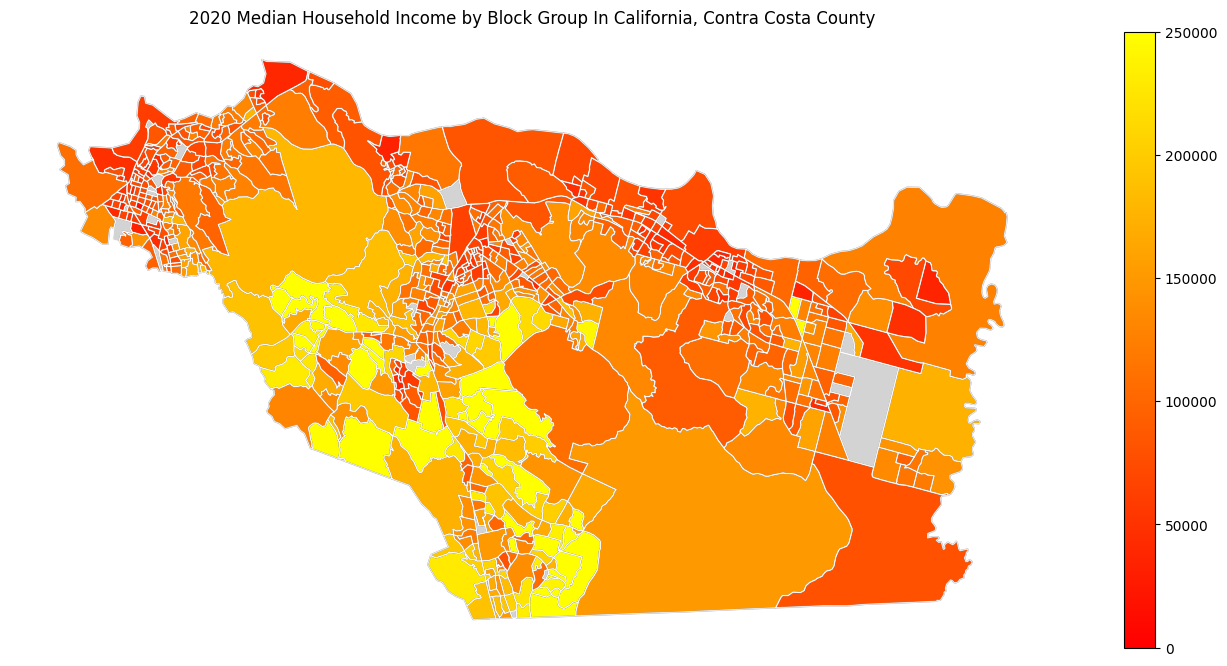

In [18]:
plot_map(
    gdf_bg,
    f"block group in {states.NAMES_FROM_IDS[STATE]}, Contra Costa County",
    max_income=250_000.0,
)

In [28]:
# Plot map for only Alameda County, California.

gdf_bg = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    county=COUNTY_Alameda_CA,
    block_group="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

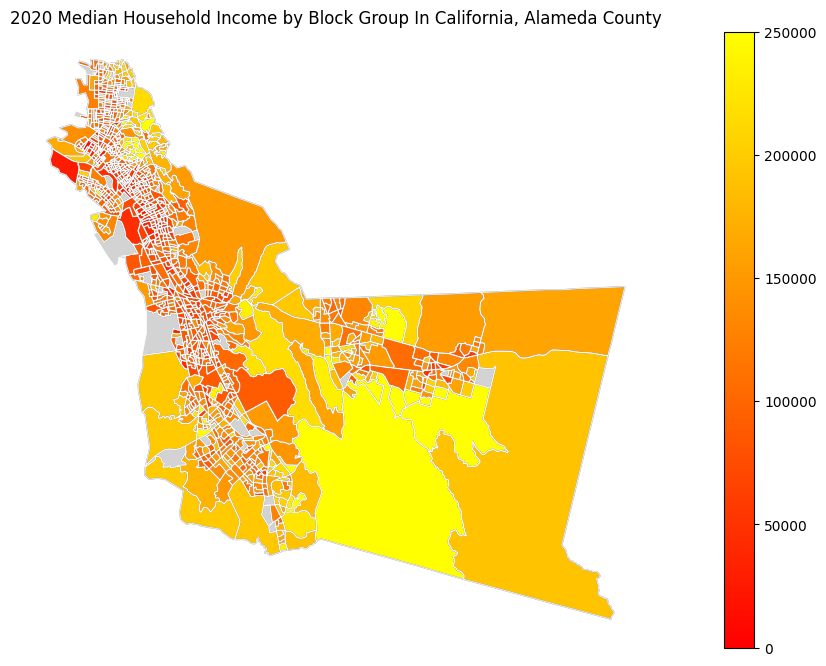

In [29]:
plot_map(
    gdf_bg,
    f"block group in {states.NAMES_FROM_IDS[STATE]}, Alameda County",
    max_income=250_000.0,
)

In [30]:
# Save the plot to a shapefile
gdf_bg.to_file("/home/veronica/data/shapefiles/ContraCosta_bg/ContraCosta_bg_income.shp")

/tmp/ipykernel_328502/465157265.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_bg.to_file("/home/veronica/data/shapefiles/ContraCosta_bg/ContraCosta_bg_income.shp")
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'BLOCK_GROUP' to 'BLOCK_GROU'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B01003_001E' to 'B01003_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B19013_001E' to 'B19013_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B25010_001E' to 'B25010_001'
  ogr_write(


In [31]:
# Plot map for census tracts in Contra Costa County, California.

gdf_tract = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    county=COUNTY_ContraCosta_CA,
    tract="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

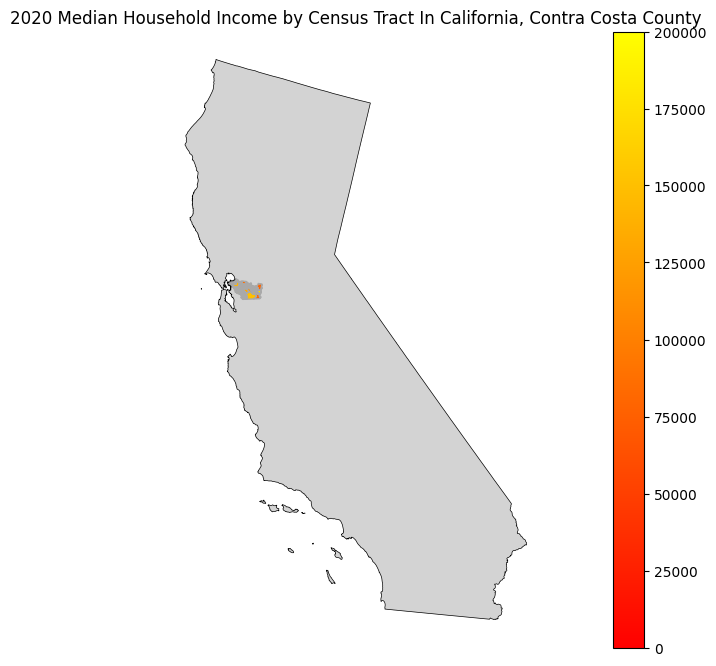

In [32]:
plot_map(
    gdf_tract,
    f"census tract in {states.NAMES_FROM_IDS[STATE]}, Contra Costa County",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

In [33]:
# Save the plot to a shapefile
gdf_tract.to_file("/home/veronica/data/shapefiles/ContraCosta_ct/ContraCosta_tract_income.shp")

/tmp/ipykernel_328502/2109750849.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_tract.to_file("/home/veronica/data/shapefiles/ContraCosta_ct/ContraCosta_tract_income.shp")
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B01003_001E' to 'B01003_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B19013_001E' to 'B19013_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B25010_001E' to 'B25010_001'
  ogr_write(


In [34]:
# Plot map for census tracts in Alameda County, California.

COUNTY_Alameda_CA = "001"  # See county query above.

gdf_tract_alameda = ced.download(
    DATASET,
    YEAR,
    VARIABLES,
    state=STATE,
    county=COUNTY_Alameda_CA,
    tract="*",
    with_geometry=True,
    set_to_nan=cev.ALL_SPECIAL_VALUES,
)

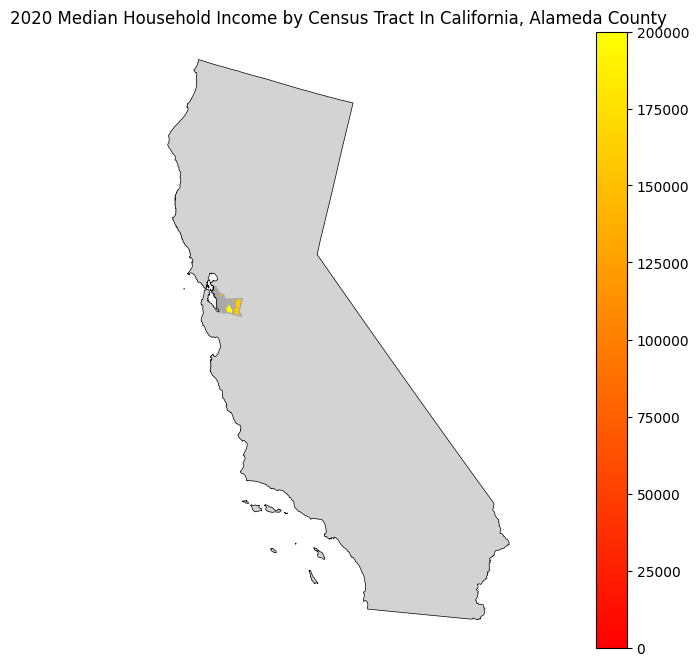

In [35]:
plot_map(
    gdf_tract_alameda,
    f"census tract in {states.NAMES_FROM_IDS[STATE]}, Alameda County",
    gdf_bounds=gdf_state_bounds[gdf_state_bounds["STATEFP"] == STATE],
    bounds_color="black",
)

In [36]:
# Save the plot to a shapefile

gdf_tract_alameda.to_file("/home/veronica/data/shapefiles/Alameda_ct/Alameda_tract_income.shp")

/tmp/ipykernel_328502/3319451682.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_tract_alameda.to_file("/home/veronica/data/shapefiles/Alameda_ct/Alameda_tract_income.shp")
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B01003_001E' to 'B01003_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B19013_001E' to 'B19013_001'
  ogr_write(
/data_1/veronica/myenv/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'B25010_001E' to 'B25010_001'
  ogr_write(
